In [ ]:
!pip install tensorflow-model-optimization --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 119.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import tensorflow as tf
from tf_keras.applications import resnet50, mobilenet, vgg19, efficientnet, mobilenet_v3, mobilenet_v2, MobileNetV3Large
from keras.api.datasets import cifar10, cifar100
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
    cluster,
)
import tf_keras as keras
import tempfile
from tf_keras import Sequential
from tf_keras.layers import Dense, Input, UpSampling2D, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, InputLayer
from tf_keras.callbacks import EarlyStopping
from tf_keras.models import Model
import random
import keras.backend as K

In [ ]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
BASE_PATH = '/content/drive/MyDrive/Mestrado/Robustness'
OPTIMIZATION_PATH = f'{BASE_PATH}/optimization'

In [ ]:
from enum import Enum

class Dataset_Type(Enum):
    CIFAR10 = 'CIFAR10'
    CIFAR100 = 'CIFAR100'

corrupted_datasets_path = {
    Dataset_Type.CIFAR10: f'{BASE_PATH}/CIFAR-10-C',
    Dataset_Type.CIFAR100: f'{BASE_PATH}/CIFAR-100-C'
}

In [ ]:
import pandas as pd
import os
import json

def generate_data_with_labels(image_dir):
    all_file_paths = []
    labels = []

    all_folds = os.listdir(image_dir)
    for fold in all_folds:
        fold_path = os.path.join(image_dir, fold)
        all_files_in_fold = os.listdir(fold_path)
        for file in all_files_in_fold:
            file_path = os.path.join(fold_path, file)
            all_file_paths.append(file_path)
            labels.append(fold)
    return pd.DataFrame(data={"file_path": all_file_paths, "labels": labels})


def save_json(output_name, data_dict):
    with open(output_name, 'w') as file:
        json.dump(data_dict, file)
    print("File save with success!")


def load_json(output_name):
    with open(output_name, 'r') as file:
        data_dict = json.load(file)
    print("File loaded with success!")

    return data_dict

def preprocess_images(images, preprocess_input):
    images = images.astype('float32')
    images = preprocess_input(images)
    return images

def evaluate_corruption_error(model, output_path, preprocess_input, x_clean_test, y_clean_test, CIFAR_C_PATH = f'{BASE_PATH}/CIFAR-100-C'):


  CORRUPTION_TYPES = {
    'blur': ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur'],
    'digital': ['contrast', 'elastic_transform', 'jpeg_compression', 'pixelate'],
    'noise': ['gaussian_noise', 'impulse_noise', 'shot_noise'],
    'weather': ['brightness', 'fog', 'frost', 'snow']
  }
  result = {
      "clean": None,
      "corruptions": {
        'blur': {},
        'digital': {},
        'noise': {},
        'weather': {}
      }
  }

  LEN_BY_SEVERITY_LEVEL = 10000
  labels = np.load(f"{CIFAR_C_PATH}/labels.npy")

  ## Evaluate clean
  preds = model.predict(x_clean_test)
  predicted_classes = np.argmax(preds, axis=1)
  accuracy = accuracy_score(y_clean_test, predicted_classes)
  result["clean"] = 1 - accuracy
  print(f"Accuracy for clean is {accuracy}")

  # Evaluate corrupted images
  for subject in CORRUPTION_TYPES.keys():
      for corruption_type in range(len(CORRUPTION_TYPES[subject])):
          corruption_name = CORRUPTION_TYPES[subject][corruption_type]
          all_images_by_corruption = np.load(f"{CIFAR_C_PATH}/{corruption_name}.npy")
          all_images_by_corruption = preprocess_images(all_images_by_corruption, preprocess_input)
          for severity in range(1, 6):
              current_images = all_images_by_corruption[LEN_BY_SEVERITY_LEVEL * (severity - 1): LEN_BY_SEVERITY_LEVEL * severity]

              current_labels = labels[LEN_BY_SEVERITY_LEVEL * (severity - 1): LEN_BY_SEVERITY_LEVEL * severity]

              preds = model.predict(current_images)
              predicted_classes = np.argmax(preds, axis=1)

              accuracy = accuracy_score(current_labels, predicted_classes)

              if corruption_name not in result["corruptions"][subject]:
                  result["corruptions"][subject][corruption_name] = {}

              result["corruptions"][subject][corruption_name][severity] = 1 - accuracy
              print(f"Accuracy for {subject}/{corruption_name}/{severity} is {accuracy}")
              save_json(output_path, result)

def build_model(base_model, base_treinable = False, dataset_type = Dataset_Type.CIFAR10):
    for layer in base_model.layers:
        layer.trainable = base_treinable

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)

    outputs = Dense(10 if dataset_type == Dataset_Type.CIFAR10 else 100, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    return model

def start_model(model, dataset_type = Dataset_Type.CIFAR10):
  inputs = Input(shape=(32,32,3))
  inputs = UpSampling2D(size=(7,7))(inputs)

  model = model(weights='imagenet', include_top=False, input_tensor=inputs)

  final_model = build_model(model, base_treinable=True, dataset_type=dataset_type)

  return final_model


In [ ]:
from enum import Enum
class QuantizationType(Enum):
    JUST_WEIGHTS = 'JUST_WEIGHTS'
    FULL_INTEGER_WITH_SUBSTITUTE_FLOAT = 'FULL_INTEGER_WITH_SUBSTITUTE_FLOAT'
    FULL_INTEGER = 'FULL_INTEGER'
    NOTHING = 'NOTHING'

def generate_quantization(result_name, model, quantization_type: QuantizationType, representative_dataset = None):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    if quantization_type != QuantizationType.NOTHING:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

    if quantization_type != QuantizationType.JUST_WEIGHTS and quantization_type != QuantizationType.NOTHING:
        if representative_dataset is None:
            raise Exception('representative_dataset is mandatory')
        converter.representative_dataset = representative_dataset

    if quantization_type == QuantizationType.FULL_INTEGER:
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8  # or tf.uint8
        converter.inference_output_type = tf.uint8  # or tf.uint8
    tflite_model = converter.convert()

    tflite_model_size = open(f"{result_name}.tflite","wb").write(tflite_model)
    print("Quantized model (DEFAULT) is {:,} bytes".format(tflite_model_size))

    return tflite_model

def representative_dataset_gen():
  for input_value in x_train_processed[:200]:
      input_value = tf.expand_dims(input_value, axis=0)
      yield [input_value]


In [ ]:
def print_model_weights_sparsity(model):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def print_model_weight_clusters(model):

    for layer in model.layers:
        if isinstance(layer, keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            if "kernel" in weight.name:
                unique_count = len(np.unique(weight))
                print(
                    f"{layer.name}/{weight.name}: {unique_count} clusters "
                )

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower right')
  plt.xlim([0,len(history.history['accuracy'])])
  plt.ylim([0.0,1.0])
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='center right')
  plt.xlim([0,len(history.history['loss'])])
  plt.show()


In [ ]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune_registry

def apply_quantization(layer):
    if isinstance(layer, tf.keras.Model):
      return tf.keras.models.clone_model(layer,clone_function=apply_quantization)

    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
      return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer



def prepare_model_for_pruning(model, pruning_params):
  def apply_pruning(layer):
    if (prune_registry.PruneRegistry.supports(layer)
        or isinstance(layer, tfmot.sparsity.keras.PrunableLayer)
        or hasattr(layer, 'get_prunable_weights')):
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

  return tf.keras.models.clone_model(
      model,
      clone_function=apply_pruning,
  )

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


SEED para o vgg tem que ser diferente de 11

In [ ]:
def resolve_seed(seed=11):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

all_preprocess_inputs = {
    'resnet50': resnet50.preprocess_input,
    'vgg19': vgg19.preprocess_input,
    'mobilenet': mobilenet.preprocess_input,
    'mobilenet_v2': mobilenet_v2.preprocess_input,
}

all_base_models = {
    'resnet50': resnet50.ResNet50,
    'vgg19': vgg19.VGG19,
    'mobilenet': mobilenet.MobileNet,
    'mobilenet_v2': mobilenet_v2.MobileNetV2
}


EPOCHS = 30

resolve_seed()

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

## Helpers

### Base model train

In [ ]:
def base_model_train(model, preprocess_input, dataset, dataset_type, base_path):
  def representative_dataset_gen():
    for input_value in x_train_processed[:200]:
        input_value = tf.expand_dims(input_value, axis=0)
        yield [input_value]

  print(f"{model} - Base Model")
  print()

  (x_train, y_train), (x_test, y_test) = dataset

  x_train_processed = preprocess_images(x_train, preprocess_input)
  x_test_processed = preprocess_images(x_test, preprocess_input)

  base_model = start_model(all_base_models[model], dataset_type)

  opt = keras.optimizers.Adam(learning_rate=1e-5)

  base_model.compile(
      optimizer=opt,
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  history = base_model.fit(
      x_train_processed,
      y_train,
      epochs=EPOCHS,
      validation_data=(x_test_processed, y_test),
      batch_size=256,
      callbacks=callbacks
  )

  df = pd.DataFrame(history.history)
  df.to_csv(f'{base_path}/history/{model}.csv', index=True)

  print(f"{model} - Plot history")
  print()
  plot_history(history)


  print(f"{model} - Saving the model... -------------")
  print()
  base_model.save(f'{base_path}/models/basic/{model}.keras')

  print(f"{model} - Generate tflite")
  print()
  quantization_none = generate_quantization(
      f'{base_path}/models/optimizations/{model}',
      base_model,
      QuantizationType.NOTHING
  )

  print(f"{model} - Generate tflite with full integer")
  print()
  full_quantization = generate_quantization(
      f'{base_path}/models/optimizations/{model}-{QuantizationType.FULL_INTEGER.value.lower()}',
      base_model,
      QuantizationType.FULL_INTEGER,
      representative_dataset=representative_dataset_gen
  )

  print(f"{model} - Evaluate corruption error -------------------")
  print()
  evaluate_corruption_error(
    base_model,
    f'{base_path}/results/ce_{model}.json',
    all_preprocess_inputs[model],
    x_test_processed,
    y_test,
    corrupted_datasets_path[dataset_type]
    )


### Pruning train

In [ ]:
def pruning_train(model, preprocess_input, dataset, dataset_type, base_path):
  def representative_dataset_gen():
    for input_value in x_train_processed[:200]:
        input_value = tf.expand_dims(input_value, axis=0)
        yield [input_value]

  print(f"{model} - Pruning Fine Tuning")
  print()
  (x_train, y_train), (x_test, y_test) = dataset

  # Get the best epoch in normal training with the model default
  df = pd.read_csv(f'{base_path}/history/{model}.csv')
  df = df.sort_values(by=['val_loss'], ascending=True)
  best_epoch = df.iloc[0]['Unnamed: 0'].astype(int)

  base_model = keras.models.load_model(f'{base_path}/models/basic/{model}.keras')

  x_train_processed = preprocess_images(x_train, all_preprocess_inputs[model])
  x_test_processed = preprocess_images(x_test, all_preprocess_inputs[model])

  pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.5,
                                                                begin_step=0,
                                                                end_step=-1)
  }

  model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(base_model, **pruning_params)
  log_dir = tempfile.mkdtemp()
  callbacks_pruning = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir),
  ]

  opt = keras.optimizers.Adam(learning_rate=1e-5)

  model_for_pruning.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  print(f"{model} - Train with the optimized number of epochs: {best_epoch}... -------------")
  print()
  history = model_for_pruning.fit(
      x_train_processed,
      y_train,
      epochs=best_epoch,
      validation_data = (x_test_processed, y_test),
      batch_size=256,
      callbacks=callbacks_pruning
      )

  print(f"{model} - Plot history")
  print()
  plot_history(history)

  df = pd.DataFrame(history.history)
  df.to_csv(f'{base_path}/history/{model}-pruning-50.csv', index=True)

  print(f"{model} - Saving the model... -------------")
  print()
  model_for_pruning.save(f'{base_path}/models/basic/{model}-pruning-50.h5', include_optimizer=False)

  model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

  print(f"{model} - Generate tflite")
  print()
  quantization_none = generate_quantization(
      f'{base_path}/models/optimizations/{model}-pruning-50',
      model_for_export,
      QuantizationType.NOTHING
  )

  print(f"{model} - Generate tflite with full integer")
  print()
  full_quantization = generate_quantization(
      f'{base_path}/models/optimizations/{model}-pruning-50-{QuantizationType.FULL_INTEGER.value.lower()}',
      model_for_export,
      QuantizationType.FULL_INTEGER,
      representative_dataset=representative_dataset_gen
  )

  print(f"{model} - Evaluate corruption error -------------------")
  print()
  evaluate_corruption_error(
    model_for_pruning,
    f'{base_path}/results/ce_{model}_pruning_50.json',
    all_preprocess_inputs[model],
    x_test_processed,
    y_test,
    corrupted_datasets_path[dataset_type]
    )

### Clustering train

In [ ]:
def clustering_train(model, preprocess_input, dataset, dataset_type, base_path):
  def representative_dataset_gen():
    for input_value in x_train_processed[:200]:
        input_value = tf.expand_dims(input_value, axis=0)
        yield [input_value]
  print(f"{model} - Weight Sharing Fine Tuning")
  print()
  (x_train, y_train), (x_test, y_test) = dataset

  cluster_weights = tfmot.clustering.keras.cluster_weights
  CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

  base_model = keras.models.load_model(f'{base_path}/models/basic/{model}.keras')

  x_train_processed = preprocess_images(x_train, all_preprocess_inputs[model])
  x_test_processed = preprocess_images(x_test, all_preprocess_inputs[model])

  clustering_params = {
    'number_of_clusters': 16,
    'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS
  }


  model_for_clustering = cluster_weights(base_model, **clustering_params)

  opt = keras.optimizers.Adam(learning_rate=1e-5)

  model_for_clustering.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  history = model_for_clustering.fit(
      x_train_processed,
      y_train,
      epochs=EPOCHS,
      validation_data = (x_test_processed, y_test),
      batch_size=256,
      callbacks=callbacks
      )

  df = pd.DataFrame(history.history)
  df.to_csv(f'{base_path}/history/{model}-clustering-16.csv', index=True)

  print(f"{model} - Plot history")
  print()
  plot_history(history)

  print(f"{model} - Saving the model... -------------")
  print()
  model_for_clustering.save(f'{base_path}/models/basic/{model}-clustering-16.h5', include_optimizer=False)

  model_for_export = tfmot.clustering.keras.strip_clustering(model_for_clustering)

  print(f"{model} - Generate tflite")
  print()
  quantization_none = generate_quantization(
      f'{base_path}/models/optimizations/{model}-clustering-16',
      model_for_export,
      QuantizationType.NOTHING
  )

  print(f"{model} - Generate tflite with full integer")
  print()
  full_quantization = generate_quantization(
      f'{base_path}/models/optimizations/{model}-clustering-16-{QuantizationType.FULL_INTEGER.value.lower()}',
      model_for_export,
      QuantizationType.FULL_INTEGER,
      representative_dataset=representative_dataset_gen
  )

  print(f"{model} - Evaluate corruption error -------------------")
  print()
  evaluate_corruption_error(
    model_for_clustering,
    f'{base_path}/results/ce_{model}_clustering_16.json',
    all_preprocess_inputs[model],
    x_test_processed,
    y_test,
    corrupted_datasets_path[dataset_type]
    )


### Quantization train

In [ ]:
def quantization_train(model, preprocess_input, dataset, dataset_type, base_path):
  def representative_dataset_gen():
    for input_value in x_train_processed[:200]:
        input_value = tf.expand_dims(input_value, axis=0)
        yield [input_value]
  print(f"{model} - Quantization")
  print()
  (x_train, y_train), (x_test, y_test) = dataset

  base_model = keras.models.load_model(f'{base_path}/models/basic/{model}.keras')

  x_train_processed = preprocess_images(x_train, all_preprocess_inputs[model])
  x_test_processed = preprocess_images(x_test, all_preprocess_inputs[model])

  print(f"{model} - Generate tflite")
  print()
  quantization_none = generate_quantization(
      f'{base_path}/models/optimizations/{model}',
      base_model,
      QuantizationType.NOTHING
  )

  print(f"{model} - Generate tflite with full integer")
  print()
  full_quantization = generate_quantization(
      f'{base_path}/models/optimizations/{model}-{QuantizationType.FULL_INTEGER.value.lower()}',
      base_model,
      QuantizationType.FULL_INTEGER,
      representative_dataset=representative_dataset_gen
  )

### QAT train

In [ ]:
def qat_train(model, preprocess_input, dataset, dataset_type, base_path):
  def representative_dataset_gen():
    for input_value in x_train_processed[:200]:
        input_value = tf.expand_dims(input_value, axis=0)
        yield [input_value]
  print(f"{model} - QAT Fine Tuning")
  print()
  (x_train, y_train), (x_test, y_test) = dataset

  base_model = keras.models.load_model(f'{base_path}/models/basic/{model}.keras')

  x_train_processed = preprocess_images(x_train, all_preprocess_inputs[model])
  x_test_processed = preprocess_images(x_test, all_preprocess_inputs[model])

  annotated_model = tf.keras.models.clone_model(
    base_model,
    clone_function=apply_quantization,
  )

  with tfmot.quantization.keras.quantize_scope():
  # Use `quantize_apply` to actually make the model quantization aware.
    quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

  # slow lr because vgg needs in this optimization type
  opt = keras.optimizers.Adam(learning_rate=1e-5)

  quant_aware_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  history = quant_aware_model.fit(
      x_train_processed,
      y_train,
      epochs=EPOCHS,
      validation_data = (x_test_processed, y_test),
      batch_size=128,
      callbacks=callbacks
      )

  df = pd.DataFrame(history.history)
  df.to_csv(f'{base_path}/history/{model}-qat.csv', index=True)

  print(f"{model} - Plot history")
  print()
  plot_history(history)

  print(f"{model} - Saving the model... -------------")
  print()
  quant_aware_model.save(f'{base_path}/models/basic/{model}-qat.h5', include_optimizer=False)

  print(f"{model} - Generate tflite")
  print()
  quantization_none = generate_quantization(
      f'{base_path}/models/optimizations/{model}-qat',
      quant_aware_model,
      QuantizationType.NOTHING
  )

  print(f"{model} - Generate tflite with full integer")
  print()
  full_quantization = generate_quantization(
      f'{base_path}/models/optimizations/{model}-qat-{QuantizationType.FULL_INTEGER.value.lower()}',
      quant_aware_model,
      QuantizationType.FULL_INTEGER,
      representative_dataset=representative_dataset_gen
  )

  print(f"{model} - Evaluate corruption error -------------------")
  print()
  evaluate_corruption_error(
    quant_aware_model,
    f'{base_path}/results/ce_{model}_qat.json',
    all_preprocess_inputs[model],
    x_test_processed,
    y_test,
    corrupted_datasets_path[dataset_type]
    )

### Sparsity preserving clustering train

In [ ]:
def sparsity_preserving_clustering_train(model, preprocess_input, dataset, dataset_type, base_path):
  def representative_dataset_gen():
    for input_value in x_train_processed[:200]:
        input_value = tf.expand_dims(input_value, axis=0)
        yield [input_value]
  from tensorflow_model_optimization.python.core.clustering.keras.experimental import (
    cluster,
  )
  cluster_weights = cluster.cluster_weights
  CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

  print(f"{model} - Sparsity Preserving Weight Sharing Fine Tuning")
  print()
  (x_train, y_train), (x_test, y_test) = dataset

  print(f"{model} - Sparsity Preserving Weight Sharing Fine Tuning")
  print()

  print(f"{model} - Loading pruned model... -------------")
  print()

  x_train_processed = preprocess_images(x_train, all_preprocess_inputs[model])
  x_test_processed = preprocess_images(x_test, all_preprocess_inputs[model])
  with tfmot.sparsity.keras.prune_scope():
    loaded_model_pruned = keras.models.load_model(f'{base_path}/models/basic/{model}-pruning-50.h5')

    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(loaded_model_pruned)

    stripped_pruned_model_copy = keras.models.clone_model(stripped_pruned_model)
    stripped_pruned_model_copy.set_weights(stripped_pruned_model.get_weights())

  clustering_params = {
    'number_of_clusters': 16,
    'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
    'preserve_sparsity': True
  }

  sparsity_clustered_model = cluster_weights(stripped_pruned_model_copy, **clustering_params)

  opt = keras.optimizers.Adam(learning_rate=1e-5)

  sparsity_clustered_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
    )

  history = sparsity_clustered_model.fit(
    x_train_processed,
    y_train,
    epochs=EPOCHS,
    validation_data = (x_test_processed, y_test),
    batch_size=256,
    callbacks=callbacks
    )

  df = pd.DataFrame(history.history)
  df.to_csv(f'{base_path}/history/{model}-pruning-50-clustering-16.csv', index=True)

  print(f"{model} - Plot history")
  print()
  plot_history(history)

  print(f"{model} - Saving the model... -------------")
  print()
  sparsity_clustered_model.save(
      f'{base_path}/models/basic/{model}-pruning-50-clustering-16.keras'
      )

  model_for_export = tfmot.clustering.keras.strip_clustering(sparsity_clustered_model)

  print(f"{model} - Generate tflite")
  print()
  quantization_none = generate_quantization(
      f'{base_path}/models/optimizations/{model}-pruning-50-clustering-16',
      model_for_export,
      QuantizationType.NOTHING
  )

  print(f"{model} - Generate tflite with full integer")
  print()
  full_quantization = generate_quantization(
      f'{base_path}/models/optimizations/{model}-pruning-50-clustering-16-{QuantizationType.FULL_INTEGER.value.lower()}',
      model_for_export,
      QuantizationType.FULL_INTEGER,
      representative_dataset=representative_dataset_gen
  )

  print(f"{model} - Evaluate corruption error -------------------")
  print()
  evaluate_corruption_error(
    sparsity_clustered_model,
    f'{base_path}/results/ce_{model}_pruning_50_clustering_16.json',
    all_preprocess_inputs[model],
    x_test_processed,
    y_test,
    corrupted_datasets_path[dataset_type]
    )

### CQAT train

In [ ]:
def cqat_train(model, preprocess_input, dataset, dataset_type, base_path):
  def representative_dataset_gen():
    for input_value in x_train_processed[:200]:
        input_value = tf.expand_dims(input_value, axis=0)
        yield [input_value]
  print(f"{model} - CQAT Fine Tuning")
  print()
  (x_train, y_train), (x_test, y_test) = dataset

  print(f"{model} - Loading pruned model... -------------")
  print()

  x_train_processed = preprocess_images(x_train, all_preprocess_inputs[model])
  x_test_processed = preprocess_images(x_test, all_preprocess_inputs[model])
  with tfmot.clustering.keras.cluster_scope():
    loaded_model_clustered = keras.models.load_model(f'{base_path}/models/basic/{model}-clustering-16.h5')
    stripped_clustered_model = tfmot.clustering.keras.strip_clustering(loaded_model_clustered)

  quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              stripped_clustered_model)

  cqat_model = tfmot.quantization.keras.quantize_apply(
                quant_aware_annotate_model,
                tfmot.experimental.combine.Default8BitClusterPreserveQuantizeScheme())

  opt = keras.optimizers.Adam(learning_rate=1e-5)

  cqat_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
    )

  history = cqat_model.fit(
    x_train_processed,
    y_train,
    epochs=EPOCHS,
    validation_data = (x_test_processed, y_test),
    batch_size=64,
    callbacks=callbacks
    )

  df = pd.DataFrame(history.history)
  df.to_csv(f'{base_path}/history/{model}-clustering-16-qat.csv', index=True)

  print(f"{model} - Plot history")
  print()
  plot_history(history)

  print(f"{model} - Saving the model... -------------")
  print()
  cqat_model.save(
      f'{base_path}/models/basic/{model}-clustering-16-qat.keras'
      )


  print(f"{model} - Generate tflite")
  print()
  quantization_none = generate_quantization(
      f'{base_path}/models/optimizations/{model}-clustering-16-qat',
      cqat_model,
      QuantizationType.NOTHING
  )

  print(f"{model} - Generate tflite with full integer")
  print()
  full_quantization = generate_quantization(
      f'{base_path}/models/optimizations/{model}-clustering-16-qat-{QuantizationType.FULL_INTEGER.value.lower()}',
      cqat_model,
      QuantizationType.FULL_INTEGER,
      representative_dataset=representative_dataset_gen
  )

  print(f"{model} - Evaluate corruption error -------------------")
  print()
  evaluate_corruption_error(
    cqat_model,
    f'{base_path}/results/ce_{model}_clustering_16_qat.json',
    all_preprocess_inputs[model],
    x_test_processed,
    y_test,
    corrupted_datasets_path[dataset_type]
    )


### PQAT train

In [ ]:
def pqat_train(model, preprocess_input, dataset, dataset_type, base_path):
  def representative_dataset_gen():
    for input_value in x_train_processed[:200]:
        input_value = tf.expand_dims(input_value, axis=0)
        yield [input_value]

  print(f"{model} - PQAT Fine Tuning")
  print()

  (x_train, y_train), (x_test, y_test) = dataset

  print(f"{model} - Loading pruned model... -------------")
  print()

  x_train_processed = preprocess_images(x_train, all_preprocess_inputs[model])
  x_test_processed = preprocess_images(x_test, all_preprocess_inputs[model])

  with tfmot.sparsity.keras.prune_scope():
    loaded_model_pruned = keras.models.load_model(f'{base_path}/models/basic/{model}-pruning-50.h5')

    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(loaded_model_pruned)
    stripped_pruned_model_copy = keras.models.clone_model(stripped_pruned_model)
    stripped_pruned_model_copy.set_weights(stripped_pruned_model.get_weights())


  quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(
              stripped_pruned_model_copy)

  pqat_model = tfmot.quantization.keras.quantize_apply(
                quant_aware_annotate_model,
                tfmot.experimental.combine.Default8BitPrunePreserveQuantizeScheme())

  opt = keras.optimizers.Adam(learning_rate=1e-5)

  pqat_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
    )

  history = pqat_model.fit(
    x_train_processed,
    y_train,
    epochs=EPOCHS,
    validation_data = (x_test_processed, y_test),
    batch_size=64,
    callbacks=callbacks
    )

  df = pd.DataFrame(history.history)
  df.to_csv(f'{base_path}/history/{model}-pruning-50-qat.csv', index=True)

  print(f"{model} - Plot history")
  print()
  plot_history(history)

  print(f"{model} - Saving the model... -------------")
  print()
  pqat_model.save(
      f'{base_path}/models/basic/{model}-pruning-50-qat.keras'
      )


  print(f"{model} - Generate tflite")
  print()
  quantization_none = generate_quantization(
      f'{base_path}/models/optimizations/{model}-pruning-50-qat',
      pqat_model,
      QuantizationType.NOTHING
  )

  print(f"{model} - Generate tflite with full integer")
  print()
  full_quantization = generate_quantization(
      f'{base_path}/models/optimizations/{model}-pruning-50-qat-{QuantizationType.FULL_INTEGER.value.lower()}',
      pqat_model,
      QuantizationType.FULL_INTEGER,
      representative_dataset=representative_dataset_gen
  )

  print(f"{model} - Evaluate corruption error -------------------")
  print()
  evaluate_corruption_error(
    pqat_model,
    f'{base_path}/results/ce_{model}_pruning_50_qat.json',
    all_preprocess_inputs[model],
    x_test_processed,
    y_test,
    corrupted_datasets_path[dataset_type]
    )

### PCQAT train

In [ ]:
def pcqat_train(model, preprocess_input, dataset, dataset_type, base_path):
  def representative_dataset_gen():
    for input_value in x_train_processed[:200]:
        input_value = tf.expand_dims(input_value, axis=0)
        yield [input_value]

  print(f"{model} - PCQAT Fine Tuning")
  print()

  print(f"{model} - Loading pruned sparsity model... -------------")
  print()

  (x_train, y_train), (x_test, y_test) = dataset

  x_train_processed = preprocess_images(x_train, all_preprocess_inputs[model])
  x_test_processed = preprocess_images(x_test, all_preprocess_inputs[model])

  with tfmot.clustering.keras.cluster_scope():
    sparsity_clustered_model = keras.models.load_model(f'{base_path}/models/basic/{model}-pruning-50-clustering-16.keras')
    sparsity_clustered_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_model)

  quant_aware_annotate_model = tfmot.quantization.keras.quantize_annotate_model(sparsity_clustered_model)
  pcqat_model = tfmot.quantization.keras.quantize_apply(
                quant_aware_annotate_model,
                tfmot.experimental.combine.Default8BitClusterPreserveQuantizeScheme(preserve_sparsity=True))

  opt = keras.optimizers.Adam(learning_rate=1e-5)

  pcqat_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
    )

  history = pcqat_model.fit(
    x_train_processed,
    y_train,
    epochs=EPOCHS,
    validation_data = (x_test_processed, y_test),
    batch_size=64,
    callbacks=callbacks
    )

  df = pd.DataFrame(history.history)
  df.to_csv(f'{base_path}/history/{model}-pruning-50-clustering-16-qat.csv', index=True)

  print(f"{model} - Plot history")
  print()
  plot_history(history)

  print(f"{model} - Saving the model... -------------")
  print()
  pcqat_model.save(
      f'{base_path}/models/basic/{model}-pruning-50-clustering-16-qat.keras'
      )

  print(f"{model} - Generate tflite")
  print()
  quantization_none = generate_quantization(
      f'{base_path}/models/optimizations/{model}-pruning-50-clustering-16-qat',
      pcqat_model,
      QuantizationType.NOTHING
  )

  print(f"{model} - Generate tflite with full integer")
  print()
  full_quantization = generate_quantization(
      f'{base_path}/models/optimizations/{model}-pruning-50-clustering-16-qat-{QuantizationType.FULL_INTEGER.value.lower()}',
      pcqat_model,
      QuantizationType.FULL_INTEGER,
      representative_dataset=representative_dataset_gen
  )

  print(f"{model} - Evaluate corruption error -------------------")
  print()
  evaluate_corruption_error(
    pcqat_model,
    f'{base_path}/results/ce_{model}_pruning_50_clustering_16_qat.json',
    all_preprocess_inputs[model],
    x_test_processed,
    y_test,
    corrupted_datasets_path[dataset_type]
    )

# New Version

In [ ]:
# Cifar 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Cifar 100
# (x_train, y_train), (x_test, y_test) = cifar100.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Base model

mobilenet_v2 - Base Model



9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/30
196/196 [==============================] - 71s 222ms/step - loss: 1.5607 - accuracy: 0.5001 - val_loss: 1.8430 - val_accuracy: 0.3377
Epoch 2/30
196/196 [==============================] - 40s 203ms/step - loss: 0.7647 - accuracy: 0.7476 - val_loss: 1.6011 - val_accuracy: 0.4351
Epoch 3/30
196/196 [==============================] - 40s 203ms/step - loss: 0.5396 - accuracy: 0.8188 - val_loss: 1.4011 - val_accuracy: 0.5179
Epoch 4/30
196/196 [==============================] - 40s 203ms/step - loss: 0.4222 - accuracy: 0.8576 - val_loss: 1.2213 - val_accuracy: 0.5835
Epoch 5/30
196/196 [==============================] - 40s 203ms/step - loss: 0.3456 - accuracy: 0.8838 - val_loss: 0.9995 - val_accuracy: 0.6561
Epoch 6/30
196/196 [==============================] - 40s 203ms/step - loss: 0.2913 - accuracy: 0.9027 - val_loss: 0.8702 - val_accuracy: 0.7011
Epoch 7/30
196/196 [==============================] - 40s 203ms/ste

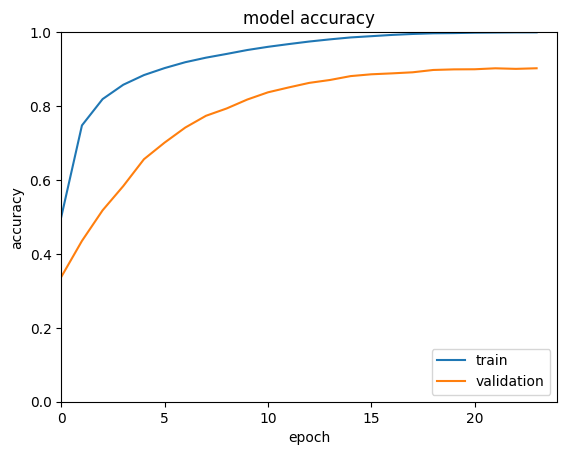

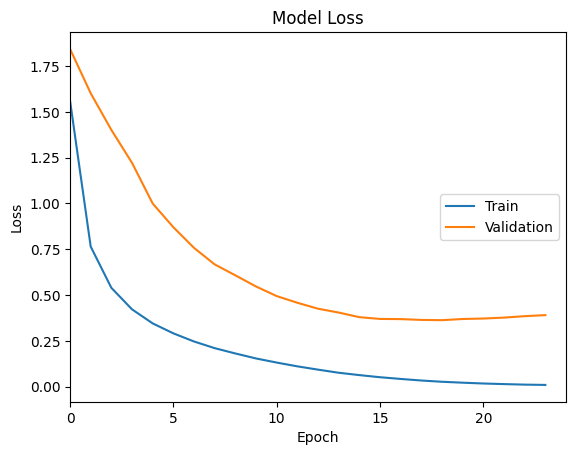

mobilenet_v2 - Saving the model... -------------

mobilenet_v2 - Generate tflite

Quantized model (DEFAULT) is 14,141,432 bytes
mobilenet_v2 - Generate tflite with full integer



/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model (DEFAULT) is 4,048,744 bytes
mobilenet_v2 - Evaluate corruption error -------------------

313/313 [==============================] - 3s 7ms/step
Accuracy for clean is 0.8976
313/313 [==============================] - 2s 7ms/step
Accuracy for blur/defocus_blur/1 is 0.8884
File save with success!
313/313 [==============================] - 2s 7ms/step
Accuracy for blur/defocus_blur/2 is 0.8506
File save with success!
313/313 [==============================] - 2s 7ms/step
Accuracy for blur/defocus_blur/3 is 0.7733
File save with success!
313/313 [==============================] - 2s 7ms/step
Accuracy for blur/defocus_blur/4 is 0.6739
File save with success!
313/313 [==============================] - 2s 7ms/step
Accuracy for blur/defocus_blur/5 is 0.4685
File save with success!
313/313 [==============================] - 2s 7ms/step
Accuracy for blur/glass_blur/1 is 0.3498
File save with success!
313/313 [==============================] - 2s 7ms/step
Accuracy for blur/glass_

In [ ]:
for model in all_preprocess_inputs.keys():
  base_model_train(
      model,
      all_preprocess_inputs[model],
       ((x_train, y_train), (x_test, y_test)),
       Dataset_Type.CIFAR10,
      f'{OPTIMIZATION_PATH}/{model}'
      )


## Pruning

mobilenet_v2 - Pruning Fine Tuning

mobilenet_v2 - Train with the optimized number of epochs: 18... -------------

Epoch 1/18
  6/196 [..............................] - ETA: 52s - loss: 0.0225 - accuracy: 0.9974

196/196 [==============================] - 99s 244ms/step - loss: 0.2067 - accuracy: 0.9307 - val_loss: 4.8539 - val_accuracy: 0.1156
Epoch 2/18
196/196 [==============================] - 45s 228ms/step - loss: 0.3124 - accuracy: 0.8908 - val_loss: 4.5383 - val_accuracy: 0.1293
Epoch 3/18
196/196 [==============================] - 45s 229ms/step - loss: 0.2573 - accuracy: 0.9089 - val_loss: 3.5350 - val_accuracy: 0.1898
Epoch 4/18
196/196 [==============================] - 45s 229ms/step - loss: 0.2240 - accuracy: 0.9214 - val_loss: 2.6658 - val_accuracy: 0.3077
Epoch 5/18
196/196 [==============================] - 45s 228ms/step - loss: 0.1982 - accuracy: 0.9313 - val_loss: 1.8371 - val_accuracy: 0.4729
Epoch 6/18
196/196 [==============================] - 45s 228ms/step - loss: 0.1761 - accuracy: 0.9396 - val_loss: 1.3172 - val_accuracy: 0.5994
Epoch 7/18
196/196 [==============================] - 45s 228ms/step - loss: 0.1565 - accuracy: 0.9474 - val_loss: 0.9598 - val_accuracy: 0.7

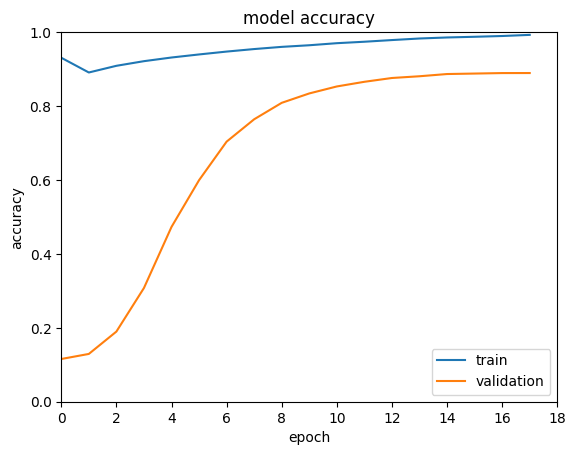

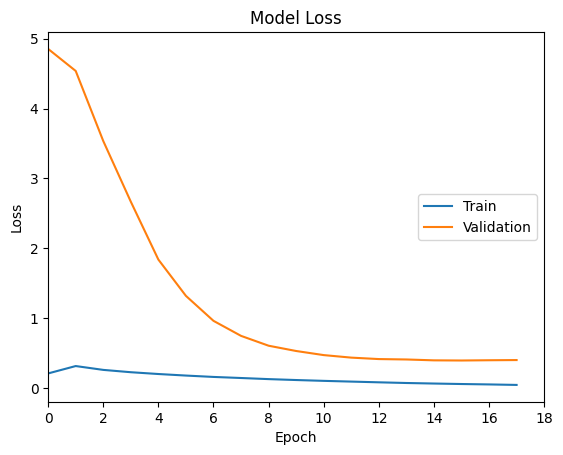

mobilenet_v2 - Saving the model... -------------



/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


mobilenet_v2 - Generate tflite

Quantized model (DEFAULT) is 14,141,432 bytes
mobilenet_v2 - Generate tflite with full integer



/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model (DEFAULT) is 4,048,744 bytes
mobilenet_v2 - Evaluate corruption error -------------------

313/313 [==============================] - 4s 8ms/step
Accuracy for clean is 0.889
313/313 [==============================] - 3s 8ms/step
Accuracy for blur/defocus_blur/1 is 0.8834
File save with success!
313/313 [==============================] - 3s 8ms/step
Accuracy for blur/defocus_blur/2 is 0.8551
File save with success!
313/313 [==============================] - 3s 8ms/step
Accuracy for blur/defocus_blur/3 is 0.7859
File save with success!
313/313 [==============================] - 3s 8ms/step
Accuracy for blur/defocus_blur/4 is 0.6772
File save with success!
313/313 [==============================] - 3s 8ms/step
Accuracy for blur/defocus_blur/5 is 0.475
File save with success!
313/313 [==============================] - 3s 8ms/step
Accuracy for blur/glass_blur/1 is 0.3367
File save with success!
313/313 [==============================] - 3s 8ms/step
Accuracy for blur/glass_bl

In [ ]:
for model in all_preprocess_inputs.keys():
  pruning_train(
      model,
      all_preprocess_inputs[model],
       ((x_train, y_train), (x_test, y_test)),
       Dataset_Type.CIFAR10,
      f'{OPTIMIZATION_PATH}/{model}'
      )


mobilenet_v2 - Weight Sharing Fine Tuning

Epoch 1/30
196/196 [==============================] - 74s 221ms/step - loss: 0.8728 - accuracy: 0.7080 - val_loss: 0.5678 - val_accuracy: 0.8054
Epoch 2/30
196/196 [==============================] - 41s 210ms/step - loss: 0.4574 - accuracy: 0.8416 - val_loss: 0.5599 - val_accuracy: 0.8157
Epoch 3/30
196/196 [==============================] - 41s 210ms/step - loss: 0.3709 - accuracy: 0.8709 - val_loss: 0.4109 - val_accuracy: 0.8599
Epoch 4/30
196/196 [==============================] - 41s 210ms/step - loss: 0.3003 - accuracy: 0.8962 - val_loss: 0.3863 - val_accuracy: 0.8662
Epoch 5/30
196/196 [==============================] - 41s 210ms/step - loss: 0.2580 - accuracy: 0.9101 - val_loss: 0.3529 - val_accuracy: 0.8819
Epoch 6/30
196/196 [==============================] - 41s 210ms/step - loss: 0.2228 - accuracy: 0.9230 - val_loss: 0.3332 - val_accuracy: 0.8879
Epoch 7/30
196/196 [==============================] - 41s 210ms/step - loss: 0.1962 - a

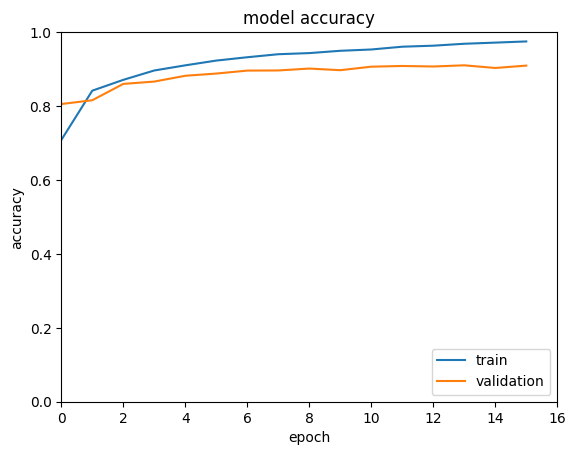

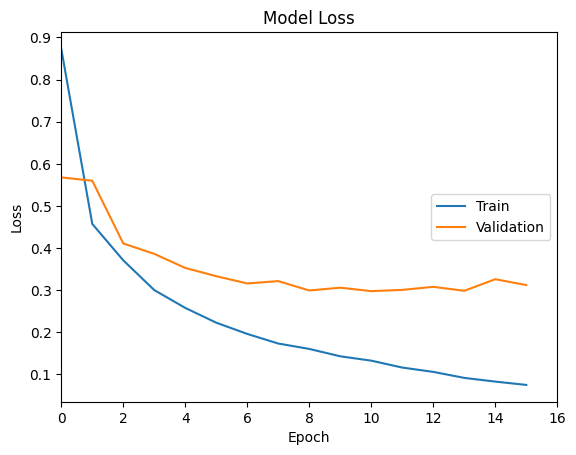

mobilenet_v2 - Saving the model... -------------



/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


mobilenet_v2 - Generate tflite

Quantized model (DEFAULT) is 14,141,432 bytes
mobilenet_v2 - Generate tflite with full integer



/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model (DEFAULT) is 4,048,744 bytes
mobilenet_v2 - Evaluate corruption error -------------------

313/313 [==============================] - 6s 12ms/step
Accuracy for clean is 0.9065
313/313 [==============================] - 4s 13ms/step
Accuracy for blur/defocus_blur/1 is 0.9007
File save with success!
313/313 [==============================] - 4s 13ms/step
Accuracy for blur/defocus_blur/2 is 0.8723
File save with success!
313/313 [==============================] - 4s 13ms/step
Accuracy for blur/defocus_blur/3 is 0.8037
File save with success!
313/313 [==============================] - 4s 13ms/step
Accuracy for blur/defocus_blur/4 is 0.7044
File save with success!
313/313 [==============================] - 4s 13ms/step
Accuracy for blur/defocus_blur/5 is 0.4877
File save with success!
313/313 [==============================] - 4s 12ms/step
Accuracy for blur/glass_blur/1 is 0.4095
File save with success!
313/313 [==============================] - 4s 12ms/step
Accuracy for blu

In [ ]:
for model in all_preprocess_inputs.keys():
  clustering_train(
      model,
      all_preprocess_inputs[model],
       ((x_train, y_train), (x_test, y_test)),
       Dataset_Type.CIFAR10,
      f'{OPTIMIZATION_PATH}/{model}'
      )


In [ ]:
for model in all_preprocess_inputs.keys():
  quantization_train(
      model,
      all_preprocess_inputs[model],
       ((x_train, y_train), (x_test, y_test)),
       Dataset_Type.CIFAR10,
      f'{OPTIMIZATION_PATH}/{model}'
      )

mobilenet_v2 - Quantization

mobilenet_v2 - Generate tflite

Quantized model (DEFAULT) is 14,141,432 bytes
mobilenet_v2 - Generate tflite with full integer



/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model (DEFAULT) is 4,048,744 bytes


mobilenet_v2 - QAT Fine Tuning

Epoch 1/30
391/391 [==============================] - 159s 330ms/step - loss: 0.3388 - accuracy: 0.8845 - val_loss: 0.3749 - val_accuracy: 0.8799
Epoch 2/30
391/391 [==============================] - 127s 324ms/step - loss: 0.1499 - accuracy: 0.9474 - val_loss: 0.3571 - val_accuracy: 0.8888
Epoch 3/30
391/391 [==============================] - 127s 324ms/step - loss: 0.1040 - accuracy: 0.9631 - val_loss: 0.3305 - val_accuracy: 0.8977
Epoch 4/30
391/391 [==============================] - 126s 323ms/step - loss: 0.0860 - accuracy: 0.9702 - val_loss: 0.3362 - val_accuracy: 0.8942
Epoch 5/30
391/391 [==============================] - 127s 324ms/step - loss: 0.0720 - accuracy: 0.9759 - val_loss: 0.3167 - val_accuracy: 0.9003
Epoch 6/30
391/391 [==============================] - 127s 324ms/step - loss: 0.0615 - accuracy: 0.9804 - val_loss: 0.3181 - val_accuracy: 0.9048
Epoch 7/30
391/391 [==============================] - 127s 324ms/step - loss: 0.0512 - accur

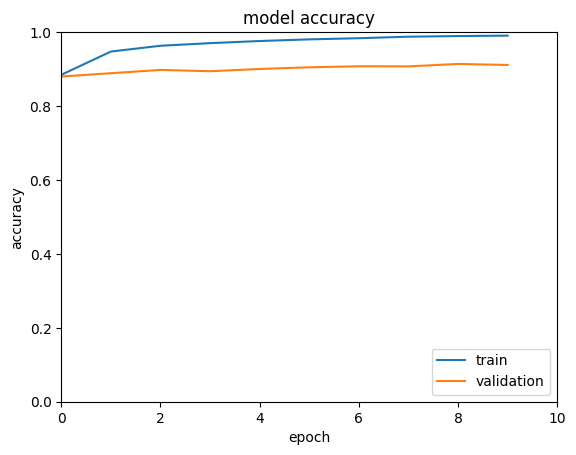

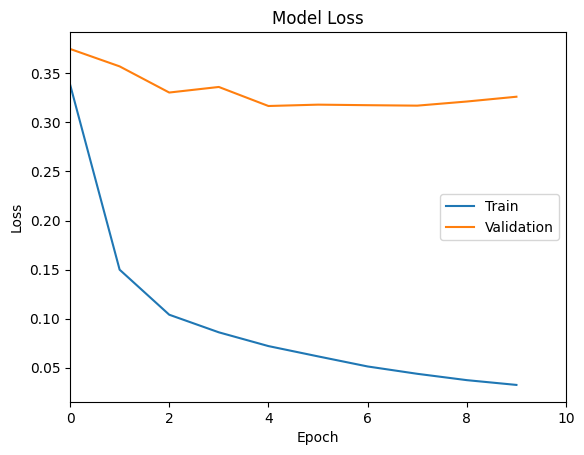

mobilenet_v2 - Saving the model... -------------



/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


mobilenet_v2 - Generate tflite

Quantized model (DEFAULT) is 14,377,552 bytes
mobilenet_v2 - Generate tflite with full integer



/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model (DEFAULT) is 4,045,848 bytes
mobilenet_v2 - Evaluate corruption error -------------------

313/313 [==============================] - 24s 70ms/step
Accuracy for clean is 0.9014
313/313 [==============================] - 22s 70ms/step
Accuracy for blur/defocus_blur/1 is 0.8967
File save with success!
313/313 [==============================] - 22s 70ms/step
Accuracy for blur/defocus_blur/2 is 0.8539
File save with success!
313/313 [==============================] - 22s 70ms/step
Accuracy for blur/defocus_blur/3 is 0.7739
File save with success!
313/313 [==============================] - 22s 71ms/step
Accuracy for blur/defocus_blur/4 is 0.6622
File save with success!
313/313 [==============================] - 22s 70ms/step
Accuracy for blur/defocus_blur/5 is 0.4395
File save with success!
313/313 [==============================] - 22s 70ms/step
Accuracy for blur/glass_blur/1 is 0.3753
File save with success!
313/313 [==============================] - 22s 70ms/step
Accuracy

In [ ]:
for model in all_preprocess_inputs.keys():
  qat_train(
      model,
      all_preprocess_inputs[model],
       ((x_train, y_train), (x_test, y_test)),
       Dataset_Type.CIFAR10,
      f'{OPTIMIZATION_PATH}/{model}'
      )

mobilenet_v2 - CQAT Fine Tuning

mobilenet_v2 - Loading pruned model... -------------



Epoch 1/30


782/782 [==============================] - 512s 408ms/step - loss: 0.4044 - accuracy: 0.8619 - val_loss: 0.5201 - val_accuracy: 0.8303
Epoch 2/30
782/782 [==============================] - 315s 402ms/step - loss: 0.2444 - accuracy: 0.9147 - val_loss: 0.4992 - val_accuracy: 0.8335
Epoch 3/30
782/782 [==============================] - 315s 402ms/step - loss: 0.2151 - accuracy: 0.9235 - val_loss: 0.4253 - val_accuracy: 0.8592
Epoch 4/30
782/782 [==============================] - 315s 402ms/step - loss: 0.1960 - accuracy: 0.9311 - val_loss: 0.3185 - val_accuracy: 0.8916
Epoch 5/30
782/782 [==============================] - 315s 402ms/step - loss: 0.1787 - accuracy: 0.9358 - val_loss: 0.4166 - val_accuracy: 0.8712
Epoch 6/30
782/782 [==============================] - 315s 403ms/step - loss: 0.1587 - accuracy: 0.9429 - val_loss: 0.3577 - val_accuracy: 0.8858
Epoch 7/30
782/782 [==============================] - 315s 403ms/step - loss: 0.1428 - accuracy: 0.9483 - val_loss: 0.4990 - val_accura

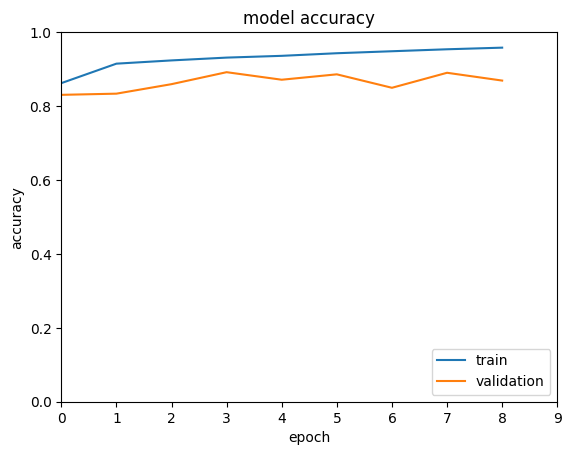

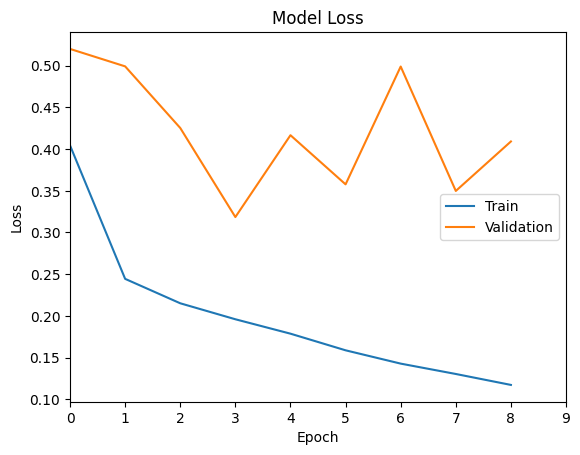

mobilenet_v2 - Saving the model... -------------

mobilenet_v2 - Generate tflite

Quantized model (DEFAULT) is 14,399,960 bytes
mobilenet_v2 - Generate tflite with full integer



/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model (DEFAULT) is 4,030,088 bytes
mobilenet_v2 - Evaluate corruption error -------------------

313/313 [==============================] - 26s 73ms/step
Accuracy for clean is 0.892
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/1 is 0.889
File save with success!
313/313 [==============================] - 23s 73ms/step
Accuracy for blur/defocus_blur/2 is 0.8603
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/3 is 0.8026
File save with success!
313/313 [==============================] - 23s 73ms/step
Accuracy for blur/defocus_blur/4 is 0.6952
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/5 is 0.4791
File save with success!
313/313 [==============================] - 23s 73ms/step
Accuracy for blur/glass_blur/1 is 0.3489
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy f

In [ ]:
for model in all_preprocess_inputs.keys():
  cqat_train(
      model,
      all_preprocess_inputs[model],
       ((x_train, y_train), (x_test, y_test)),
       Dataset_Type.CIFAR10,
      f'{OPTIMIZATION_PATH}/{model}'
      )

mobilenet_v2 - Sparsity Preserving Weight Sharing Fine Tuning

mobilenet_v2 - Sparsity Preserving Weight Sharing Fine Tuning

mobilenet_v2 - Loading pruned model... -------------



Epoch 1/30
196/196 [==============================] - 78s 236ms/step - loss: 1.1804 - accuracy: 0.6171 - val_loss: 0.6873 - val_accuracy: 0.7768
Epoch 2/30
196/196 [==============================] - 43s 220ms/step - loss: 0.4986 - accuracy: 0.8299 - val_loss: 0.4844 - val_accuracy: 0.8414
Epoch 3/30
196/196 [==============================] - 43s 220ms/step - loss: 0.3733 - accuracy: 0.8682 - val_loss: 0.4332 - val_accuracy: 0.8566
Epoch 4/30
196/196 [==============================] - 43s 220ms/step - loss: 0.3161 - accuracy: 0.8885 - val_loss: 0.3964 - val_accuracy: 0.8665
Epoch 5/30
196/196 [==============================] - 43s 219ms/step - loss: 0.2769 - accuracy: 0.9016 - val_loss: 0.4039 - val_accuracy: 0.8641
Epoch 6/30
196/196 [==============================] - 43s 220ms/step - loss: 0.2490 - accuracy: 0.9110 - val_loss: 0.3688 - val_accuracy: 0.8785
Epoch 7/30
196/196 [==============================] - 43s 220ms/step - loss: 0.2260 - accuracy: 0.9194 - val_loss: 0.3615 - val_ac

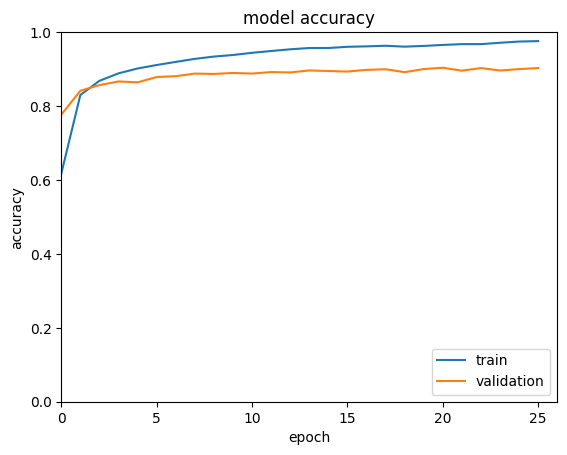

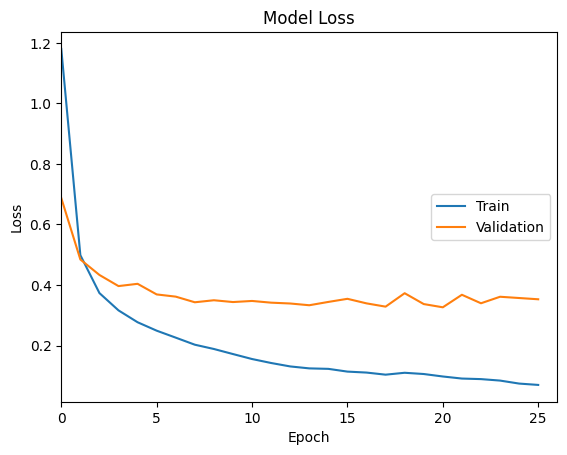

mobilenet_v2 - Saving the model... -------------

mobilenet_v2 - Generate tflite

Quantized model (DEFAULT) is 14,141,432 bytes
mobilenet_v2 - Generate tflite with full integer



/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model (DEFAULT) is 4,048,744 bytes
mobilenet_v2 - Evaluate corruption error -------------------

313/313 [==============================] - 9s 19ms/step
Accuracy for clean is 0.9035
313/313 [==============================] - 6s 19ms/step
Accuracy for blur/defocus_blur/1 is 0.8998
File save with success!
313/313 [==============================] - 6s 19ms/step
Accuracy for blur/defocus_blur/2 is 0.8755
File save with success!
313/313 [==============================] - 6s 19ms/step
Accuracy for blur/defocus_blur/3 is 0.816
File save with success!
313/313 [==============================] - 6s 19ms/step
Accuracy for blur/defocus_blur/4 is 0.7217
File save with success!
313/313 [==============================] - 6s 20ms/step
Accuracy for blur/defocus_blur/5 is 0.5184
File save with success!
313/313 [==============================] - 6s 19ms/step
Accuracy for blur/glass_blur/1 is 0.3919
File save with success!
313/313 [==============================] - 6s 19ms/step
Accuracy for blur

In [ ]:
for model in all_preprocess_inputs.keys():
  sparsity_preserving_clustering_train(
      model,
      all_preprocess_inputs[model],
       ((x_train, y_train), (x_test, y_test)),
       Dataset_Type.CIFAR10,
      f'{OPTIMIZATION_PATH}/{model}'
      )

mobilenet_v2 - PQAT Fine Tuning

mobilenet_v2 - Loading pruned model... -------------



Epoch 1/30
782/782 [==============================] - 231s 259ms/step - loss: 0.3490 - accuracy: 0.8837 - val_loss: 0.5036 - val_accuracy: 0.8462
Epoch 2/30
782/782 [==============================] - 200s 255ms/step - loss: 0.1523 - accuracy: 0.9453 - val_loss: 0.3890 - val_accuracy: 0.8796
Epoch 3/30
782/782 [==============================] - 200s 256ms/step - loss: 0.1091 - accuracy: 0.9619 - val_loss: 0.3798 - val_accuracy: 0.8847
Epoch 4/30
782/782 [==============================] - 200s 255ms/step - loss: 0.0892 - accuracy: 0.9691 - val_loss: 0.3538 - val_accuracy: 0.8940
Epoch 5/30
782/782 [==============================] - 200s 255ms/step - loss: 0.0773 - accuracy: 0.9738 - val_loss: 0.3844 - val_accuracy: 0.8882
Epoch 6/30
782/782 [==============================] - 200s 256ms/step - loss: 0.0702 - accuracy: 0.9767 - val_loss: 0.3586 - val_accuracy: 0.8964
Epoch 7/30
782/782 [==============================] - 200s 256ms/step - loss: 0.0608 - accuracy: 0.9810 - val_loss: 0.4006 -

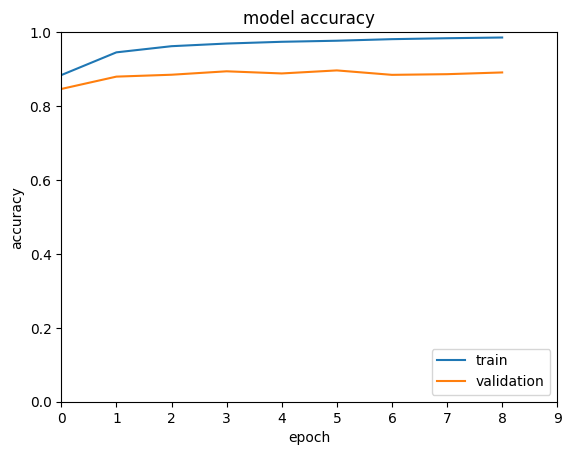

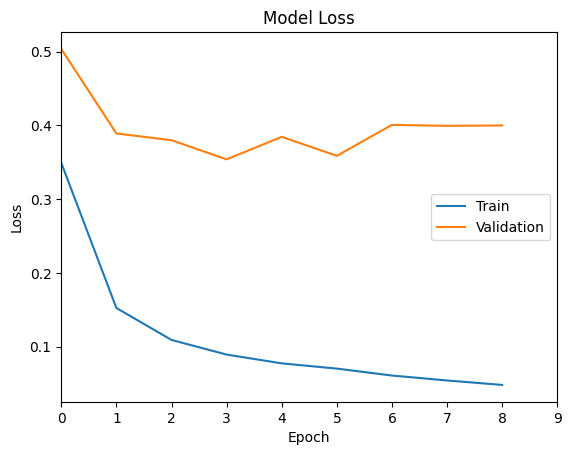

mobilenet_v2 - Saving the model... -------------

mobilenet_v2 - Generate tflite

Quantized model (DEFAULT) is 14,399,968 bytes
mobilenet_v2 - Generate tflite with full integer



/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model (DEFAULT) is 4,030,088 bytes
mobilenet_v2 - Evaluate corruption error -------------------

313/313 [==============================] - 25s 73ms/step
Accuracy for clean is 0.896
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/1 is 0.8866
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/2 is 0.8398
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/3 is 0.7502
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/4 is 0.6312
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/5 is 0.4155
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/glass_blur/1 is 0.3577
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy 

In [ ]:
for model in all_preprocess_inputs.keys():
  pqat_train(
      model,
      all_preprocess_inputs[model],
       ((x_train, y_train), (x_test, y_test)),
       Dataset_Type.CIFAR10,
      f'{OPTIMIZATION_PATH}/{model}'
      )

mobilenet_v2 - PCQAT Fine Tuning

mobilenet_v2 - Loading pruned sparsity model... -------------

Epoch 1/30


782/782 [==============================] - 257s 280ms/step - loss: 0.6712 - accuracy: 0.7735 - val_loss: 3.3160 - val_accuracy: 0.2541
Epoch 2/30
782/782 [==============================] - 216s 277ms/step - loss: 0.4402 - accuracy: 0.8469 - val_loss: 1.6069 - val_accuracy: 0.5550
Epoch 3/30
782/782 [==============================] - 216s 277ms/step - loss: 0.3689 - accuracy: 0.8700 - val_loss: 0.5478 - val_accuracy: 0.8165
Epoch 4/30
782/782 [==============================] - 217s 277ms/step - loss: 0.3385 - accuracy: 0.8819 - val_loss: 0.4808 - val_accuracy: 0.8402
Epoch 5/30
782/782 [==============================] - 217s 277ms/step - loss: 0.3078 - accuracy: 0.8914 - val_loss: 0.9648 - val_accuracy: 0.6831
Epoch 6/30
782/782 [==============================] - 217s 278ms/step - loss: 0.2784 - accuracy: 0.9002 - val_loss: 0.4202 - val_accuracy: 0.8571
Epoch 7/30
782/782 [==============================] - 218s 278ms/step - loss: 0.2517 - accuracy: 0.9113 - val_loss: 0.4565 - val_accura

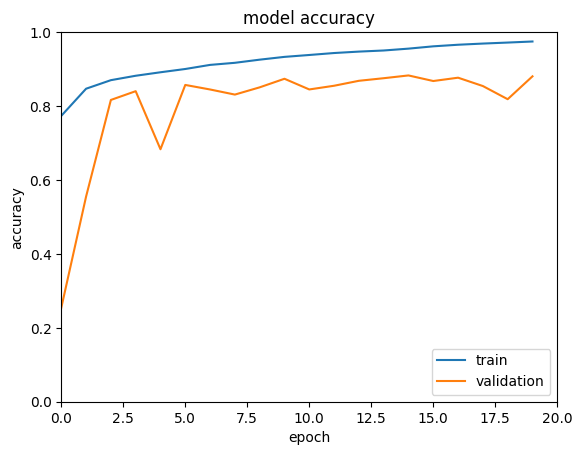

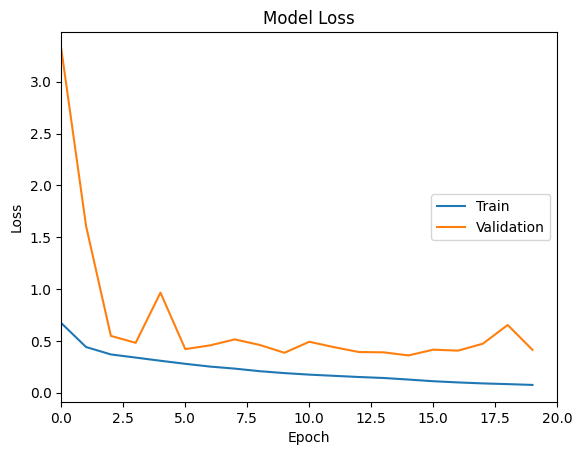

mobilenet_v2 - Saving the model... -------------

mobilenet_v2 - Generate tflite

Quantized model (DEFAULT) is 14,399,968 bytes
mobilenet_v2 - Generate tflite with full integer



/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model (DEFAULT) is 4,030,088 bytes
mobilenet_v2 - Evaluate corruption error -------------------

313/313 [==============================] - 25s 74ms/step
Accuracy for clean is 0.8844
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/1 is 0.8728
File save with success!
313/313 [==============================] - 23s 75ms/step
Accuracy for blur/defocus_blur/2 is 0.8343
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/3 is 0.7585
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/4 is 0.6596
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy for blur/defocus_blur/5 is 0.4512
File save with success!
313/313 [==============================] - 23s 75ms/step
Accuracy for blur/glass_blur/1 is 0.3686
File save with success!
313/313 [==============================] - 23s 74ms/step
Accuracy

In [ ]:
for model in all_preprocess_inputs.keys():
  pcqat_train(
      model,
      all_preprocess_inputs[model],
       ((x_train, y_train), (x_test, y_test)),
       Dataset_Type.CIFAR10,
      f'{OPTIMIZATION_PATH}/{model}'
      )